In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    project_dir = '/v/global/user/c/ch/chenyu36/workspace_vi/AllenSDK/'
    sys.path.append('/v/global/user/c/ch/chenyu36/workspace_vi/AllenSDK/jitter/')
    manifest_path = '/v/global/user/c/ch/chenyu36/workspace_vi/AllenSDK/Data/Allen_Institute_Dataset/manifest.json'
else:
    print('Add new computer system settings.')

import itertools
import matplotlib.pyplot as plt
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from datetime import datetime
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [5]:
%%time
# Check basic statistics of all probes.
probes = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())
display(selected_units.groupby(['probe_description', 'ecephys_structure_acronym']).last())

# Then select subset of probes.
probes = ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
print('final selected probes', probes)

# V1, LM, RL, IP, AL, PM, AM (needs manual sort for different anymals.)
area_hierarchy = ['probeC', 'probeD', 'probeF', 'probeE', 'probeA']  # 798911424

probeC    94
probeE    89
probeA    78
probeD    78
probeB    57
probeF    47
Name: probe_description, dtype: int64

443

,,L_ratio,presence_ratio,isolation_distance,snr,waveform_duration,nn_miss_rate,waveform_recovery_slope,waveform_velocity_below,firing_rate,cluster_id,local_index_unit,waveform_repolarization_slope,waveform_halfwidth,max_drift,waveform_PT_ratio,cumulative_drift,waveform_spread,amplitude_cutoff,d_prime,waveform_amplitude,peak_channel_id,silhouette_score,nn_hit_rate,waveform_velocity_above,isi_violations,c50_dg,area_rf,fano_dg,fano_fl,fano_ns,fano_rf,fano_sg,f1_f0_dg,g_dsi_dg,g_osi_dg,g_osi_sg,azimuth_rf,mod_idx_dg,p_value_rf,pref_sf_sg,pref_tf_dg,run_mod_dg,run_mod_fl,run_mod_ns,run_mod_rf,run_mod_sg,pref_ori_dg,pref_ori_sg,run_pval_dg,run_pval_fl,run_pval_ns,run_pval_rf,run_pval_sg,elevation_rf,pref_image_ns,pref_phase_sg,firing_rate_dg,firing_rate_fl,firing_rate_ns,firing_rate_rf,firing_rate_sg,on_off_ratio_fl,time_to_peak_ns,pref_sf_multi_sg,pref_tf_multi_dg,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_image_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
probe_description,ecephys_structure_acronym,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
probeA,VISam,0.015568,0.99,56.873778,2.217387,0.714238,0.004750,-0.015566,0.755444,2.330244,392,385,0.182642,0.247236,40.75,0.374745,459.38,50.0,0.022298,4.275154,64.803765,849855994,0.125534,0.963333,2.060302,0.125646,0.060341,700.0,3.257075,0.826667,0.756547,1.308333,0.322535,0.342330,0.025033,0.340267,0.625045,82.857,1.248681,0.000,0.04,1.0,0.027656,0.618182,0.309144,0.611111,0.180976,0.0,0.0,0.876909,0.082969,0.000228,0.216980,7.776317e-04,10.000,4992,0.00,3.965416,0.586179,2.079605,0.878294,5.096403,NaN,0.1165,False,False,False,False,False,0.830508,False,0.488876,0.064000,0.695607,0.460287,0.631725,2700,11,800036196,269,394.0,7613.0,481.0,7559.0,See electrode locations,29999.965974,1249.998582,True
probeB,VISam,0.009419,0.99,535.883528,2.231816,0.233501,0.054688,-0.034283,0.327032,17.989545,287,279,0.239873,0.178559,25.63,0.191810,182.65,90.0,0.009865,4.790931,53.481090,849854722,0.101824,0.997333,0.686767,0.012760,0.124518,300.0,1.427952,1.081905,0.741379,0.708527,1.058712,0.182809,0.045579,0.082039,0.072583,40.000,0.740204,0.000,0.04,2.0,0.140547,0.409060,0.221643,0.305556,0.092159,0.0,150.0,0.007933,0.000027,0.001777,0.035865,3.235461e-01,50.000,4992,0.00,18.205227,18.144899,20.948526,8.370656,24.441554,NaN,0.1225,False,False,False,False,False,0.272542,False,0.021480,0.001556,0.031615,0.167023,0.025828,2560,27,800036198,255,394.0,7943.0,476.0,7422.0,See electrode locations,29999.917201,1249.996550,True
probeC,VISp,0.042912,0.99,37.973009,1.832974,0.755444,0.006829,-0.018379,0.686767,1.047711,420,400,0.131790,0.247236,35.20,0.487796,427.14,60.0,0.021331,2.867965,50.750505,849853312,0.079066,0.575630,1.030151,0.294413,1.065773,900.0,3.230108,1.253333,1.165714,1.911111,0.940000,0.929324,0.091061,0.228532,0.396523,44.444,4.818274,0.000,0.32,2.0,-0.135593,-0.684783,0.570520,-1.000000,0.558036,0.0,0.0,0.693759,0.286903,0.005894,0.009152,2.096170e-04,14.444,4984,0.25,0.822312,0.186511,1.217805,0.678731,1.402826,NaN,0.0915,False,False,False,False,False,0.504254,False,0.373882,0.675676,0.320768,0.586041,0.418974,2360,59,800036200,234,385.0,9130.0,827.0,8239.0,See electrode locations,29999.996048,1249.999835,True
probeD,VISl,0.014502,0.99,56.397459,2.002475,1.263652,0.000921,-0.065126,0.206030,1.574157,393,377,0.010473,0.192295,23.77,13.146540,232.75,60.0,0.010090,5.281608,51.905490,849851976,0.171867,0.962000,0.000000,0.202876,0.565196,300.0,3.110256,0.911667,0.628213,3.533333,1.270639,1.575176,0.294153,0.941154,0.674843,13.333,0.096218,0.007,0.08,1.0,0.676190,0.278997,0.238298,0

final selected probes ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
Wall time: 13.3 s


#### Fine Time Coupling Model

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [7]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261, 278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257], all 4, 8 Hz

In [8]:
condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
2  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  265 temp freq [4.0] orient [135.0] contrast [0.8] [ 3824  3848  3880  3920  3953  3955  3960  3968  3973  3992 31039 31093 49232 49339 49383]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [9]:
%%time
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


Wall time: 1min 49s


In [10]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(386, 165)

# Fit individual filter + raw filter clustering.

In [54]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeA', 'probeC', 'probeD', 'probeE', 'probeF'], num_areas=5, verbose=False)

conditions: [(0, 249), (1, 257), (2, 258), (3, 260), (4, 261), (5, 265), (6, 270), (7, 274), (8, 278), (9, 280), (10, 286)]


In [55]:
select_condition_ids = condition_ids

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3801  3810  3813  3814  3816  3817  3822  3824  3826  3828  3835  3844  3848  3862  3866  3870  3872  3875
  3876  3878  3880  3888  3895  3897  3898  3900  3905  3911  3914  3920  3922  3925  3928  3930  3932  3933
  3934  3936  3937  3943  3946  3948  3949  3953  3955  3956  3960  3962  3964  3967  3968  3973  3980  3984
  3986  3987  3992  3996  3997 31002 31020 31021 31022 31027 31028 31033 31039 31043 31046 31053 31054 31055
 31062 31064 31075 31080 31093 31096 31104 31114 31129 31142 31148 31151 31152 31154 31156 31159 31161 31162
 31165 31167 31171 31173 31174 31175 31177 31178 31182 31184 31185 31187 31188 31190 31194 31196 31199 49211
 49215 49217 49225 49226 49228 49230 49232 49240 49250 49251 49254 49257 49263 49266 49268 49274 49275 49280
 49281 49282 49286 49290 49304 49307 49313 49317 49320 49322 49328 49332 49339 49340 49341 49349 49361 49364
 49365 49367 49368 49370 49374 49383 49390 49395 49400 49401 49405 49407 49410 49411 49414 49415 49418 49420
 49422 49428 49430]

### Between probes.

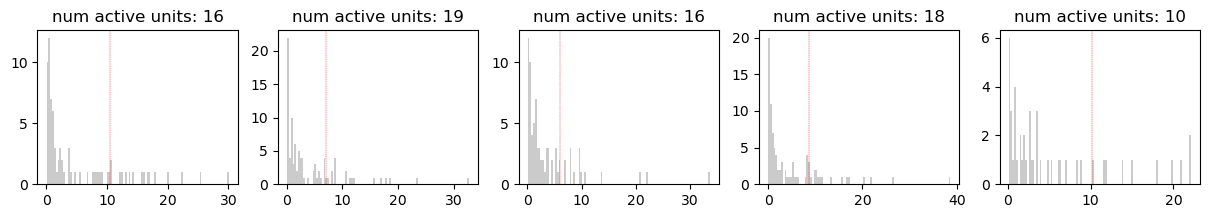

In [68]:
active_firing_rate_quantile_threshold = 0.8
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)


('probeA', 'probeC')
area paris [('probeA', 'probeC')]
num_pairs: 80
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.22s/it]
optimal kernel width  50.0


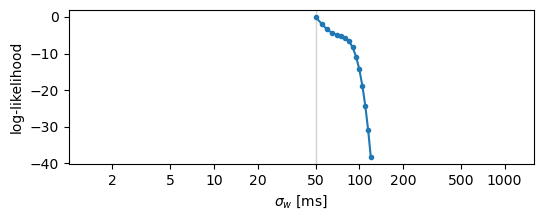

100%|███████████████████████████████████████████████████████████████| 80/80 [01:01<00:00,  1.30it/s]
num_models 80
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeA_to_probeC_31_01_2023_000826.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951092303,951103361,0.218485,0.591033,probeA,probeC,VISam,VISp
951092488,951103361,0.803798,-0.107838,probeA,probeC,VISam,VISp
951092973,951103361,0.865976,-0.078476,probeA,probeC,VISam,VISp
951092949,951103361,0.010110,1.335128,probeA,probeC,VISam,VISp
951092940,951103361,0.011890,0.938906,probeA,probeC,VISam,VISp
...,...,...,...,...,...,...,...
951092949,951104192,0.000848,2.354494,probeA,probeC,VISam,VISp
951092940,951104192,0.018086,1.178421,probeA,probeC,VISam,VISp
951093080,951104192,0.402398,0.494952,probeA,probeC,VISam,VISp


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeA_to_probeC_31_01_2023_000826.parquet
('probeA', 'probeD')
area paris [('probeA', 'probeD')]
num_pairs: 64
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.22s/it]
optimal kernel width  110.0


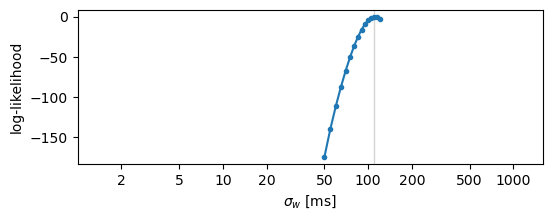

100%|███████████████████████████████████████████████████████████████| 64/64 [00:48<00:00,  1.33it/s]
num_models 64
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeA_to_probeD_31_01_2023_000934.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951092303,951108557,9.896148e-01,0.004286,probeA,probeD,VISam,VISl
951092488,951108557,5.846777e-04,1.005694,probeA,probeD,VISam,VISl
951092973,951108557,1.711176e-02,0.762795,probeA,probeD,VISam,VISl
951092949,951108557,4.058397e-02,0.747799,probeA,probeD,VISam,VISl
951092940,951108557,1.715922e-06,1.181746,probeA,probeD,VISam,VISl
...,...,...,...,...,...,...,...
951092949,951109435,5.498328e-10,2.194962,probeA,probeD,VISam,VISl
951092940,951109435,9.894060e-08,1.242283,probeA,probeD,VISam,VISl
951093080,951109435,2.103244e-06,1.354400,probeA,probeD,VISam,VISl


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeA_to_probeD_31_01_2023_000934.parquet
('probeA', 'probeE')
area paris [('probeA', 'probeE')]
num_pairs: 72
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.24s/it]
optimal kernel width  90.0


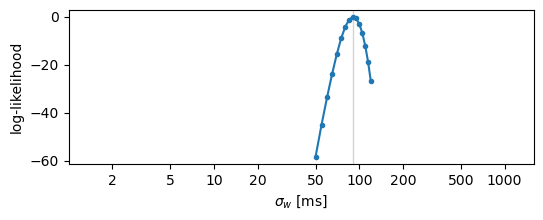

100%|███████████████████████████████████████████████████████████████| 72/72 [01:04<00:00,  1.12it/s]
num_models 72
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeA_to_probeE_31_01_2023_001059.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951092303,951112638,7.079252e-01,-0.164294,probeA,probeE,VISam,VISal
951092488,951112638,1.739061e-03,1.181981,probeA,probeE,VISam,VISal
951092973,951112638,1.020141e-04,1.554747,probeA,probeE,VISam,VISal
951092949,951112638,5.107026e-15,3.604853,probeA,probeE,VISam,VISal
951092940,951112638,4.745049e-06,1.486739,probeA,probeE,VISam,VISal
...,...,...,...,...,...,...,...
951092949,951113464,6.276293e-07,2.272962,probeA,probeE,VISam,VISal
951092940,951113464,3.820244e-05,1.283250,probeA,probeE,VISam,VISal
951093080,951113464,9.260613e-04,1.206314,probeA,probeE,VISam,VISal


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeA_to_probeE_31_01_2023_001059.parquet
('probeC', 'probeA')
area paris [('probeC', 'probeA')]
num_pairs: 80
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.23s/it]
optimal kernel width  70.0


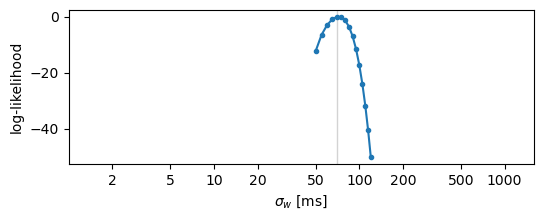

100%|███████████████████████████████████████████████████████████████| 80/80 [01:09<00:00,  1.16it/s]
num_models 80
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeC_to_probeA_31_01_2023_001228.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951103361,951092303,0.587508,-0.232422,probeC,probeA,VISp,VISam
951103262,951092303,0.250055,-0.422720,probeC,probeA,VISp,VISam
951103238,951092303,0.396172,-0.474333,probeC,probeA,VISp,VISam
951103332,951092303,0.000081,-1.134684,probeC,probeA,VISp,VISam
951103530,951092303,0.072999,-0.810443,probeC,probeA,VISp,VISam
...,...,...,...,...,...,...,...
951103632,951093608,0.001887,1.513542,probeC,probeA,VISp,VISam
951103652,951093608,0.178035,0.697514,probeC,probeA,VISp,VISam
951103958,951093608,0.000648,1.565032,probeC,probeA,VISp,VISam


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeC_to_probeA_31_01_2023_001228.parquet
('probeC', 'probeD')
area paris [('probeC', 'probeD')]
num_pairs: 80
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]
optimal kernel width  95.0


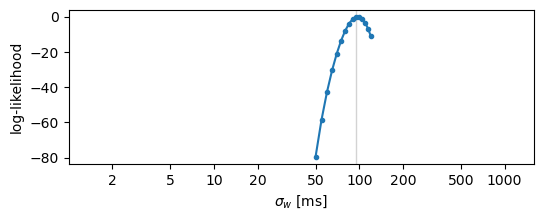

100%|███████████████████████████████████████████████████████████████| 80/80 [00:56<00:00,  1.40it/s]
num_models 80
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeC_to_probeD_31_01_2023_001345.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951103361,951108557,4.067923e-02,0.671377,probeC,probeD,VISp,VISl
951103262,951108557,5.098874e-01,-0.180236,probeC,probeD,VISp,VISl
951103238,951108557,6.796440e-01,0.172303,probeC,probeD,VISp,VISl
951103332,951108557,4.401654e-01,0.201699,probeC,probeD,VISp,VISl
951103530,951108557,3.238435e-01,-0.345232,probeC,probeD,VISp,VISl
...,...,...,...,...,...,...,...
951103632,951109435,3.445826e-07,2.066005,probeC,probeD,VISp,VISl
951103652,951109435,9.521835e-04,1.140984,probeC,probeD,VISp,VISl
951103958,951109435,1.763034e-13,2.727298,probeC,probeD,VISp,VISl


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeC_to_probeD_31_01_2023_001345.parquet
('probeC', 'probeE')
area paris [('probeC', 'probeE')]
num_pairs: 90
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]
optimal kernel width  50.0


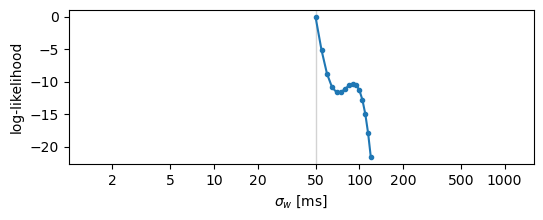

100%|███████████████████████████████████████████████████████████████| 90/90 [01:13<00:00,  1.23it/s]
num_models 90
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeC_to_probeE_31_01_2023_001518.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951103361,951112638,4.081773e-03,1.278368,probeC,probeE,VISp,VISal
951103262,951112638,4.738386e-04,1.312106,probeC,probeE,VISp,VISal
951103238,951112638,1.523070e-04,2.249666,probeC,probeE,VISp,VISal
951103332,951112638,9.436896e-14,2.320711,probeC,probeE,VISp,VISal
951103530,951112638,6.278826e-03,-1.351788,probeC,probeE,VISp,VISal
...,...,...,...,...,...,...,...
951103632,951113464,9.119291e-01,0.057931,probeC,probeE,VISp,VISal
951103652,951113464,3.079729e-02,1.106846,probeC,probeE,VISp,VISal
951103958,951113464,1.728800e-02,1.122028,probeC,probeE,VISp,VISal


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeC_to_probeE_31_01_2023_001518.parquet
('probeD', 'probeA')
area paris [('probeD', 'probeA')]
num_pairs: 64
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]
optimal kernel width  50.0


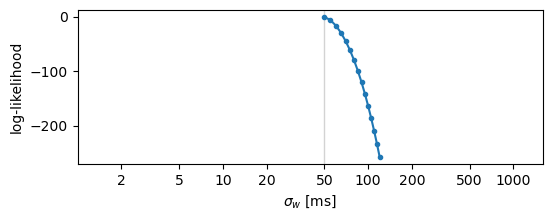

100%|███████████████████████████████████████████████████████████████| 64/64 [00:52<00:00,  1.22it/s]
num_models 64
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeD_to_probeA_31_01_2023_001630.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951108557,951092303,2.769087e-02,-1.200873,probeD,probeA,VISl,VISam
951108685,951092303,3.503072e-01,-0.515875,probeD,probeA,VISl,VISam
951108877,951092303,1.645239e-01,-0.802127,probeD,probeA,VISl,VISam
951108911,951092303,1.498376e-01,-0.756227,probeD,probeA,VISl,VISam
951109137,951092303,6.463624e-01,-0.183638,probeD,probeA,VISl,VISam
...,...,...,...,...,...,...,...
951108911,951093608,3.601264e-01,0.513387,probeD,probeA,VISl,VISam
951109137,951093608,3.902809e-03,1.128808,probeD,probeA,VISl,VISam
951109282,951093608,3.388608e-07,-2.073914,probeD,probeA,VISl,VISam


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeD_to_probeA_31_01_2023_001630.parquet
('probeD', 'probeC')
area paris [('probeD', 'probeC')]
num_pairs: 80
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.17s/it]
optimal kernel width  50.0


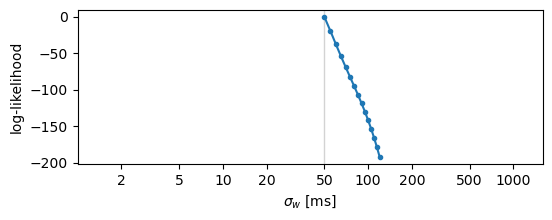

100%|███████████████████████████████████████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]
num_models 80
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeD_to_probeC_31_01_2023_001747.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951108557,951103361,7.922758e-02,-0.986936,probeD,probeC,VISl,VISp
951108685,951103361,1.593582e-01,-0.804414,probeD,probeC,VISl,VISp
951108877,951103361,9.511515e-01,-0.037297,probeD,probeC,VISl,VISp
951108911,951103361,3.049114e-01,0.559079,probeD,probeC,VISl,VISp
951109137,951103361,8.285314e-02,0.700389,probeD,probeC,VISl,VISp
...,...,...,...,...,...,...,...
951108911,951104192,6.451630e-02,1.365156,probeD,probeC,VISl,VISp
951109137,951104192,4.193016e-02,1.117160,probeD,probeC,VISl,VISp
951109282,951104192,2.016670e-04,-2.144958,probeD,probeC,VISl,VISp


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeD_to_probeC_31_01_2023_001747.parquet
('probeD', 'probeE')
area paris [('probeD', 'probeE')]
num_pairs: 72
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]
optimal kernel width  50.0


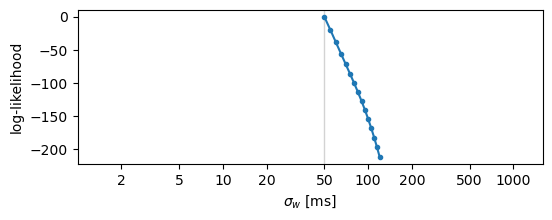

100%|███████████████████████████████████████████████████████████████| 72/72 [00:58<00:00,  1.23it/s]
num_models 72
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeD_to_probeE_31_01_2023_001905.pkl


,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951108557,951112638,9.659888e-02,-0.882146,probeD,probeE,VISl,VISal
951108685,951112638,9.293099e-01,0.046234,probeD,probeE,VISl,VISal
951108877,951112638,6.931430e-05,2.009273,probeD,probeE,VISl,VISal
951108911,951112638,2.716889e-04,1.839699,probeD,probeE,VISl,VISal
951109137,951112638,2.499334e-12,2.809225,probeD,probeE,VISl,VISal
...,...,...,...,...,...,...,...
951108911,951113464,6.792744e-01,0.213042,probeD,probeE,VISl,VISal
951109137,951113464,3.290592e-01,0.377065,probeD,probeE,VISl,VISal
951109282,951113464,4.030158e-06,-1.836808,probeD,probeE,VISl,VISal


save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeD_to_probeE_31_01_2023_001905.parquet
('probeE', 'probeA')
area paris [('probeE', 'probeA')]
num_pairs: 72
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.21s/it]
optimal kernel width  50.0


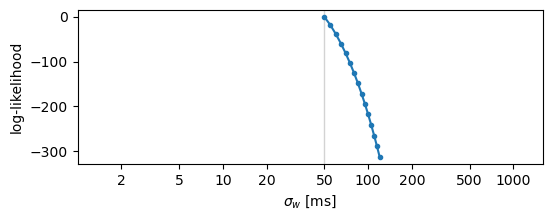

100%|███████████████████████████████████████████████████████████████| 72/72 [01:03<00:00,  1.13it/s]
num_models 72
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeE_to_probeA_31_01_2023_002028.pkl


pval         h source_probe target_probe  \
source    target                                                        
951112638 951092303  1.209685e-01 -0.732760       probeE       probeA   
951112712 951092303  5.388170e-04 -1.340344       probeE       probeA   
951112768 951092303  2.589743e-04 -1.627366       probeE       probeA   
951112992 951092303  4.014507e-01 -0.359924       probeE       probeA   
951113039 951092303  1.146571e-02 -1.013554       probeE       probeA   
...                           ...       ...          ...          ...   
          951093608  2.656608e-09  2.416463       probeE       probeA   
951113175 951093608  2.443019e-04  1.949142       probeE       probeA   
951113271 951093608  2.573257e-01  0.331802       probeE       probeA   
951113211 951093608  1.440589e-03  1.643478       probeE       probeA   
951113464 951093608  2.110525e-03  1.525521       probeE       probeA   

                    source_area target_area  
source    target                             
951112638 951092303       VISal       VISam  
951112712 951092303       VISal       VISam  
951112768 951092303       VISal       VISam  
951112992 951092303       VISal       VISam  
951113039 951092303       VISal       VISam  
...                         ...         ...  
          951093608       VISal       VISam  
951113175 951093608       VISal       VISam  
951113271 951093608       VISal       VISam  
951113211 951093608       VISal       VISam  
951113464 951093608       VISal       VISam  

[72 rows x 6 columns]

save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeE_to_probeA_31_01_2023_002028.parquet
('probeE', 'probeC')
area paris [('probeE', 'probeC')]
num_pairs: 90
100%|███████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.23s/it]
optimal kernel width  50.0


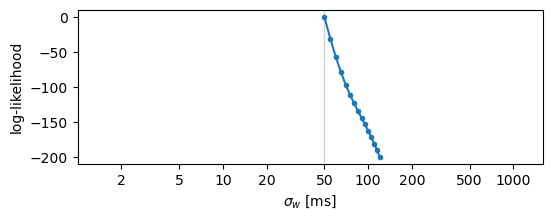

100%|███████████████████████████████████████████████████████████████| 90/90 [01:06<00:00,  1.34it/s]
num_models 90
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeE_to_probeC_31_01_2023_002155.pkl


pval         h source_probe target_probe source_area  \
source    target                                                                
951112638 951103361  0.070498 -0.858044       probeE       probeC       VISal   
951112712 951103361  0.383482 -0.348405       probeE       probeC       VISal   
951112768 951103361  0.880628  0.069716       probeE       probeC       VISal   
951112992 951103361  0.000024  1.927097       probeE       probeC       VISal   
951113039 951103361  0.087071  0.709077       probeE       probeC       VISal   
...                       ...       ...          ...          ...         ...   
          951104192  0.000407  1.859939       probeE       probeC       VISal   
951113175 951104192  0.077787  1.366727       probeE       probeC       VISal   
951113271 951104192  0.010066 -1.042807       probeE       probeC       VISal   
951113211 951104192  0.007255  1.944406       probeE       probeC       VISal   
951113464 951104192  0.120956  1.045168       probeE       probeC       VISal   

                    target_area  
source    target                 
951112638 951103361        VISp  
951112712 951103361        VISp  
951112768 951103361        VISp  
951112992 951103361        VISp  
951113039 951103361        VISp  
...                         ...  
          951104192        VISp  
951113175 951104192        VISp  
951113271 951104192        VISp  
951113211 951104192        VISp  
951113464 951104192        VISp  

[90 rows x 6 columns]

save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeE_to_probeC_31_01_2023_002156.parquet
('probeE', 'probeD')
area paris [('probeE', 'probeD')]
num_pairs: 72
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.20s/it]
optimal kernel width  50.0


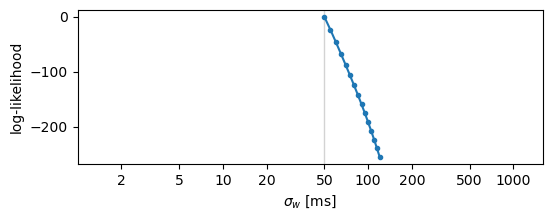

100%|███████████████████████████████████████████████████████████████| 72/72 [00:51<00:00,  1.39it/s]
num_models 72
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_model_list_probeE_to_probeD_31_01_2023_002307.pkl


pval         h source_probe target_probe  \
source    target                                                         
951112638 951108557   9.368694e-01  0.030015       probeE       probeD   
951112712 951108557  2.640257e-124 -0.551533       probeE       probeD   
951112768 951108557   2.523942e-02 -0.708312       probeE       probeD   
951112992 951108557   7.801711e-01  0.094010       probeE       probeD   
951113039 951108557   7.945982e-01  0.088231       probeE       probeD   
...                            ...       ...          ...          ...   
          951109435   1.050215e-10  0.529446       probeE       probeD   
951113175 951109435   2.688843e-01  0.465418       probeE       probeD   
951113271 951109435   7.719479e-05 -0.840776       probeE       probeD   
951113211 951109435   9.240056e-01  0.038378       probeE       probeD   
951113464 951109435   5.468932e-01 -0.218287       probeE       probeD   

                    source_area target_area  
source    target                             
951112638 951108557       VISal        VISl  
951112712 951108557       VISal        VISl  
951112768 951108557       VISal        VISl  
951112992 951108557       VISal        VISl  
951113039 951108557       VISal        VISl  
...                         ...         ...  
          951109435       VISal        VISl  
951113175 951109435       VISal        VISl  
951113271 951109435       VISal        VISl  
951113211 951109435       VISal        VISl  
951113464 951109435       VISal        VISl  

[72 rows x 6 columns]

save inference result D:/Brain_Network/Output/jitter/coupling_network/jitter_regression2/session798911424_df_inference_probeE_to_probeD_31_01_2023_002307.parquet


In [58]:
# probe_pairs = itertools.permutations(['probeA', 'probeC', 'probeD', 'probeE', 'probeF'], 2)
probe_pairs = itertools.permutations(['probeA', 'probeC', 'probeD', 'probeE',], 2)
save_dir = project_dir + f'Output/jitter/coupling_network/jitter_regression2/'

for probe_pair in probe_pairs:
    print(probe_pair)
    # ---------- Build membership ----------
    neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=[probe_pair], verbose=True)
    filter_membership = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

    # ---------- Kernel selection ----------
    kernel_width_grid = np.arange(55, 125, 5) / 1000
    _,_,optimal_kernel_width = model.estimate_nuisance_kernel_width_together(filter_membership, batch_size=2000, kernel_width_grid=kernel_width_grid)

    # ---------- Model fitting ----------
    # model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
    #              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
    #              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

    # model_par = {'filter_type': 'square', 'filter_length': 0.05,
    #              'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
    
    model_par = {'filter_type': 'square', 'filter_length': 0.04,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': optimal_kernel_width,
                 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

    model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False)
    # model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False, parallel=True, num_threads=6)

    print('num_models', len(model_list))
    timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
    model_file = save_dir + f'session{session_id}_model_list_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.pkl'
    util.save_variable(model_file, model_list)

    # ---------- Inference ----------
    df_inference = model.pairwise_bivariate_regression_inference(model_list, filter_membership)
    display(df_inference)
    timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
    output_file = save_dir + f'session{session_id}_df_inference_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.parquet'
    df_inference.to_parquet(output_file)
    print('save inference result', output_file)


### Plot significant edges

In [69]:
# load all df_inference.
import glob
inference_dir = project_dir + 'Output/jitter/coupling_network/jitter_regression2/'
files = glob.glob(inference_dir + f'session798911424_df_inference_*.parquet')

df_inference_all = []
for f in files:
    dfx = pd.read_parquet(f)
    df_inference_all.append(dfx)

df_inference_all = pd.concat(df_inference_all, axis=0)
df_inference_all

,,pval,h,source_probe,target_probe,source_area,target_area
source,target,,,,,,
951092303,951103361,2.184850e-01,0.591033,probeA,probeC,VISam,VISp
951092488,951103361,8.037977e-01,-0.107838,probeA,probeC,VISam,VISp
951092973,951103361,8.659755e-01,-0.078476,probeA,probeC,VISam,VISp
951092949,951103361,1.010961e-02,1.335128,probeA,probeC,VISam,VISp
951092940,951103361,1.189032e-02,0.938906,probeA,probeC,VISam,VISp
...,...,...,...,...,...,...,...
951113039,951109435,1.050215e-10,0.529446,probeE,probeD,VISal,VISl
951113175,951109435,2.688843e-01,0.465418,probeE,probeD,VISal,VISl
951113271,951109435,7.719479e-05,-0.840776,probeE,probeD,VISal,VISl


In [70]:
from statsmodels.stats.multitest import multipletests

test_outcome = multipletests(df_inference_all.pval.values.reshape(-1), alpha=0.01, method='bonferroni')  # fdr_by, bonferroni
df_inference_all['significant'] = test_outcome[0]
df_inference_all['h_sign'] = np.sign(df_inference_all.h)
print('adjusted p-value threshod', test_outcome[2])
display(df_inference_all.significant.value_counts())
# display(df_inference_all[df_inference_all.significant].h.value_counts(bins=[-1e10,0,1e10]))
display(df_inference_all[df_inference_all.significant].h_sign.value_counts())

adjusted p-value threshod 1.0971922180802451e-05


False    769
True     147
Name: significant, dtype: int64

 1.0    129
-1.0     18
Name: h_sign, dtype: int64

##### hierarchy analysis.

In [71]:
bottom_up_pairs = list(itertools.combinations(area_hierarchy, 2))
top_down_pairs = list(itertools.combinations(reversed(area_hierarchy), 2))
df_inference_BU = model.select_plot_edges(df_inference_all, probe_pairs=bottom_up_pairs, select_ratio=1)
df_inference_TD = model.select_plot_edges(df_inference_all, probe_pairs=top_down_pairs, select_ratio=1)

BU_pairs = set(df_inference_BU[df_inference_BU.significant].index.values)
TD_pairs_flip = set([(y,x) for (x,y) in df_inference_TD[df_inference_TD.significant].index.values])
BU_TD_intersection = BU_pairs.intersection(TD_pairs_flip)

print(len(BU_pairs))
print(len(TD_pairs_flip))
print(len(BU_TD_intersection))

probe_graph = df_inference_all[df_inference_all.significant].groupby(['source_probe', 'target_probe'])[['significant']].count()
probe_graph_BU = df_inference_BU[df_inference_BU.significant].groupby(['source_probe', 'target_probe'])[['significant']].count()
probe_graph_TD = df_inference_TD[df_inference_TD.significant].groupby(['source_probe', 'target_probe'])[['significant']].count()

display(probe_graph); display(probe_graph_BU); display(probe_graph_TD)


edge stats:
 False    386
True      72
Name: significant, dtype: int64
(0.0, 10000000000.0]       66
(-10000000000.001, 0.0]     6
Name: h, dtype: int64
edge stats:
 False    383
True      75
Name: significant, dtype: int64
(0.0, 10000000000.0]       63
(-10000000000.001, 0.0]    12
Name: h, dtype: int64
72
75
20


significant
source_probe target_probe             
probeA       probeC                  6
             probeD                 20
             probeE                 18
probeC       probeA                 12
             probeD                 19
             probeE                 22
probeD       probeA                  2
             probeC                  8
             probeE                 14
probeE       probeA                  3
             probeC                  9
             probeD                 14

significant
source_probe target_probe             
probeC       probeA                 12
             probeD                 19
             probeE                 22
probeD       probeA                  2
             probeE                 14
probeE       probeA                  3

significant
source_probe target_probe             
probeA       probeC                  6
             probeD                 20
             probeE                 18
probeD       probeC                  8
probeE       probeC                  9
             probeD                 14

##### Connection strength
hierarchy: V1, LM, RL, IP, AL, PM, AM 

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}


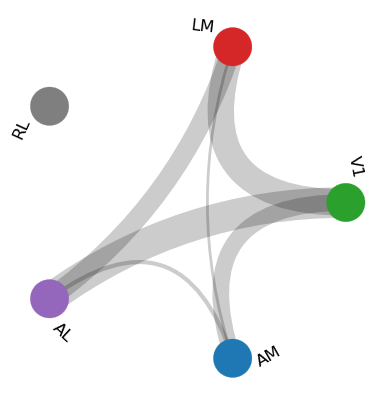

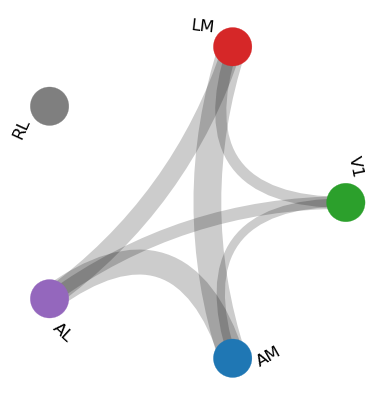

In [72]:
graph_probe_template = model.build_graph_probe_connection(probe_graph_BU, layout_probe=area_hierarchy, figure_path=None)
graph_probe_template = model.build_graph_probe_connection(probe_graph_TD, layout_probe=area_hierarchy, figure_path=None)


##### Plot all edges

num edges 147
{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_network.pdf


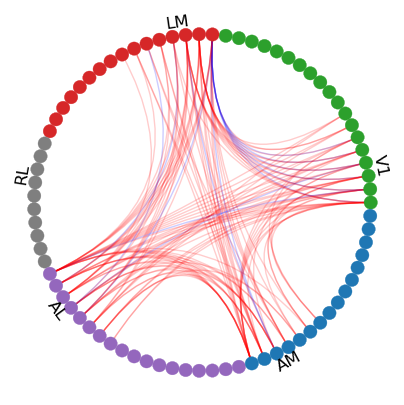

In [73]:
layout_units = active_units # df_inference_all, df_inference_plot, active_units, selected_units
figure_path = project_dir + 'Output/fig/between_probe_network.pdf'
graph_template = model.build_graph_from_regression_pval(df_inference_all, layout_units=active_units,
    layout_probe=area_hierarchy, figure_path=figure_path)

##### subset of edges

In [74]:
bottom_up_pairs = list(itertools.combinations(area_hierarchy, 2))
top_down_pairs = list(itertools.combinations(reversed(area_hierarchy), 2))
print(area_hierarchy)
print(list(bottom_up_pairs))
print(list(top_down_pairs))

['probeC', 'probeD', 'probeF', 'probeE', 'probeA']
[('probeC', 'probeD'), ('probeC', 'probeF'), ('probeC', 'probeE'), ('probeC', 'probeA'), ('probeD', 'probeF'), ('probeD', 'probeE'), ('probeD', 'probeA'), ('probeF', 'probeE'), ('probeF', 'probeA'), ('probeE', 'probeA')]
[('probeA', 'probeE'), ('probeA', 'probeF'), ('probeA', 'probeD'), ('probeA', 'probeC'), ('probeE', 'probeF'), ('probeE', 'probeD'), ('probeE', 'probeC'), ('probeF', 'probeD'), ('probeF', 'probeC'), ('probeD', 'probeC')]


edge stats:
 False    386
True      72
Name: significant, dtype: int64
(0.0, 10000000000.0]       66
(-10000000000.001, 0.0]     6
Name: h, dtype: int64
num edges 72
{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_BU_network.pdf


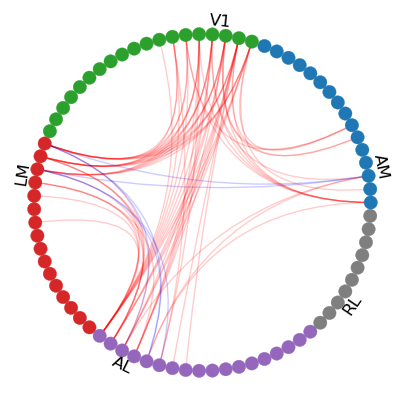

In [75]:
df_inference_plot = model.select_plot_edges(df_inference_all, probe_pairs=bottom_up_pairs, select_ratio=1)

# df_inference_all, df_inference_plot, active_units, selected_units
figure_path = project_dir + 'Output/fig/between_probe_BU_network.pdf'
graph = model.build_graph_from_regression_pval(df_inference_plot, layout_units=active_units,
    layout_probe=area_hierarchy, graph_template=graph_template.copy(), figure_path=figure_path)

edge stats:
 False    383
True      75
Name: significant, dtype: int64
(0.0, 10000000000.0]       63
(-10000000000.001, 0.0]    12
Name: h, dtype: int64
num edges 75
{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_TD_network.pdf


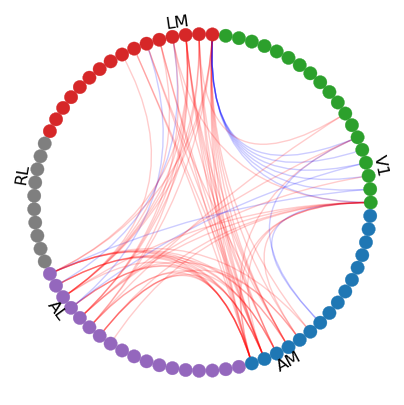

In [76]:
df_inference_plot = model.select_plot_edges(df_inference_all, probe_pairs=top_down_pairs, select_ratio=1)

# df_inference_all, df_inference_plot, active_units, selected_units
figure_path = project_dir + 'Output/fig/between_probe_TD_network.pdf'
graph = model.build_graph_from_regression_pval(df_inference_plot, layout_units=active_units,
    layout_probe=area_hierarchy, graph_template=graph_template.copy(), figure_path=figure_path)

In [78]:
BU_pairs = set(df_inference_BU[df_inference_BU.significant].index.values)
TD_pairs_flip = set([(y,x) for (x,y) in df_inference_TD[df_inference_TD.significant].index.values])
BU_TD_intersection = BU_pairs.intersection(TD_pairs_flip)
BU_TD_intersection_flip = set([(y,x) for (x,y) in BU_TD_intersection])

# print(BU_pairs)
# print(TD_pairs_flip)
# print(BU_TD_intersection)

print(len(BU_pairs))
print(len(TD_pairs_flip))
print(len(BU_TD_intersection))

df_inference_plot = df_inference_all.loc[BU_TD_intersection.union(BU_TD_intersection_flip)]
df_inference_plot

72
75
20


,,pval,h,source_probe,target_probe,source_area,target_area,significant,h_sign
source,target,,,,,,,,
951093608,951109282,0.000000e+00,4.580176,probeA,probeD,VISam,VISl,True,1.0
951109319,951103361,3.125451e-06,-1.639810,probeD,probeC,VISl,VISp,True,-1.0
951109282,951093608,3.388608e-07,-2.073914,probeD,probeA,VISl,VISam,True,-1.0
951103632,951093283,2.707296e-07,2.102633,probeC,probeA,VISp,VISam,True,1.0
951103332,951113039,5.980002e-07,1.634745,probeC,probeE,VISp,VISal,True,1.0
951103262,951112712,1.182312e-07,2.541114,probeC,probeE,VISp,VISal,True,1.0
951104192,951109319,0.000000e+00,3.242249,probeC,probeD,VISp,VISl,True,1.0
951112638,951109137,4.204910e-11,-3.557265,probeE,probeD,VISal,VISl,True,-1.0
951092940,951103332,7.714718e-12,2.389659,probeA,probeC,VISam,VISp,True,1.0


num edges 40
{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_double_dir_network.pdf


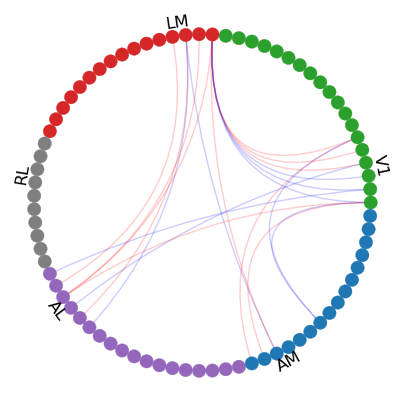

In [80]:
df_inference_plot = df_inference_all.loc[BU_TD_intersection.union(BU_TD_intersection_flip)]

# df_inference_all, df_inference_plot, active_units, selected_units
figure_path = project_dir + 'Output/fig/between_probe_double_dir_network.pdf'
graph = model.build_graph_from_regression_pval(df_inference_plot, layout_units=active_units,
    layout_probe=area_hierarchy, graph_template=graph_template.copy(), figure_path=figure_path)

# KS test

In [ ]:
model_file = project_dir + f'Output/jitter/coupling_network/session798911424_model_list_probeA_to_probeC_29_01_2023_144556.pkl'
model_list = util.load_variable(model_file)
print('num models', len(model_list))

# sub_trial_ids = spike_times.columns.values[50:70]
np.random.seed(99)
sub_trial_ids = np.random.choice(spike_times.columns.values, size=20, replace=False)
u_list_dict = model.ks_test_models_list(spike_times, trial_window, model_list, trial_ids=sub_trial_ids, verbose=False)


In [ ]:
figure_path = project_dir + f'Output/fig/test.pdf'

_=jitter.JitterTool.check_ks(np.hstack(u_list_dict.values()), test_size=0.01, bin_width=0.001, figure_path=figure_path, verbose=True)
